In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
import astropy.table as at
from astropy.table import Table
import astropy.units as u
import cmasher as cmr
from PIL import Image

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from gala.units import galactic
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

In [2]:
mwstreams = galstreams.MWStreams()

Initializing galstreams library from master_log... 


In [3]:
from ezpadova import parsec

Z = 10 ** (-2.2 + np.log10(0.0207))
iso = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="panstarrs1")
iso = iso.to_astropy_table()

iso_gaia = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="gaia")
iso_gaia = iso_gaia.to_astropy_table()
iso_gaia.remove_columns([x for x in iso_gaia.colnames if x in iso.colnames])

iso = at.hstack((iso, iso_gaia))

tmp_iso = iso[iso["stage"] == 4][1:]
HB_absmag = np.mean(tmp_iso["rP1"])

tmp_iso = iso[iso["stage"] == 1]
MSTO_absmag = tmp_iso["rP1"].min()

Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...


## Load data:

In [4]:
# tbl = at.Table.read("../data/Ibata2023_Table1.csv")
g = GaiaData(
    "../data/Ibata2023_GaiaDR3-xm.fits",
    radial_velocity_colname="vh",
    radial_velocity_unit=u.km / u.s,
)

In [5]:
tbl = at.Table.read("../data/ibata_streams_full.csv")
sID_to_name = {row["sID"]: row["name"] for row in at.unique(tbl, keys="sID")}

In [6]:
dist = g.get_distance(allow_negative=True)
dist[~np.isfinite(dist)] = 100 * u.kpc

c = g.get_skycoord(distance=dist)
# c = coord.SkyCoord(
#     ra=tbl["ra"] * u.deg,
#     dec=tbl["dec"] * u.deg,
#     distance=dist,
#     pm_ra_cosdec=tbl["mu_r"] * u.mas / u.yr,
#     pm_dec=tbl["mu_d"] * u.mas / u.yr,
#     radial_velocity=tbl["vh"] * u.km / u.s,
# )

In [7]:
gal = c.galactic

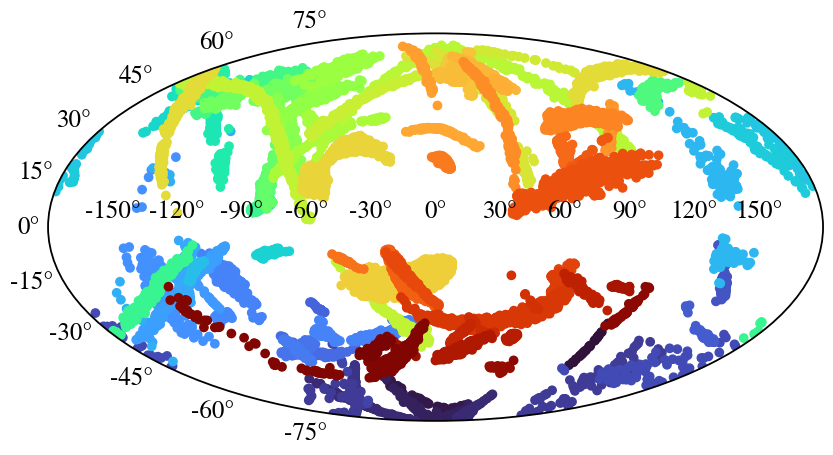

In [8]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "aitoff"})
ax.scatter(gal.l.wrap_at(180 * u.deg).radian, gal.b.radian, c=tbl["sID"], cmap="turbo")

In [9]:
np.size(np.unique(tbl['sID'])), len(tbl)

(87, 24540)

In [10]:
tbl.colnames

['id_source',
 'ra',
 'dec',
 'plx',
 'mu_r',
 'mu_d',
 'Gmag0',
 'BRcol0',
 'vh',
 'evh',
 'vsource',
 'sID',
 'year',
 'name']

## Test

In [11]:
# kinematic census
names = np.unique(tbl['name'])

ind_pmra = tbl['mu_r']!=0
ind_pmdec = tbl['mu_d']!=0
ind_vr = tbl['vh']!=0

# distance
dist = np.zeros(len(tbl)) * u.kpc

for name in names[:]:
    ind = tbl['name']==name
    med_plx = np.median(tbl['plx'][ind])
    dist[ind] = med_plx**-1 * u.kpc
#     print(name, np.sum(ind), np.sum(ind & ind_pmra), np.sum(ind & ind_pmdec), np.sum(ind & ind_vr))

In [12]:
# c = coord.SkyCoord(ra=tbl['ra']*u.deg, dec=tbl['dec']*u.deg, distance=np.abs(tbl['plx']**-1)*u.kpc)
c = coord.SkyCoord(ra=tbl['ra']*u.deg, dec=tbl['dec']*u.deg, distance=dist)
cgal = c.transform_to(coord.Galactocentric())

/tmp/ipykernel_17864/3176191562.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


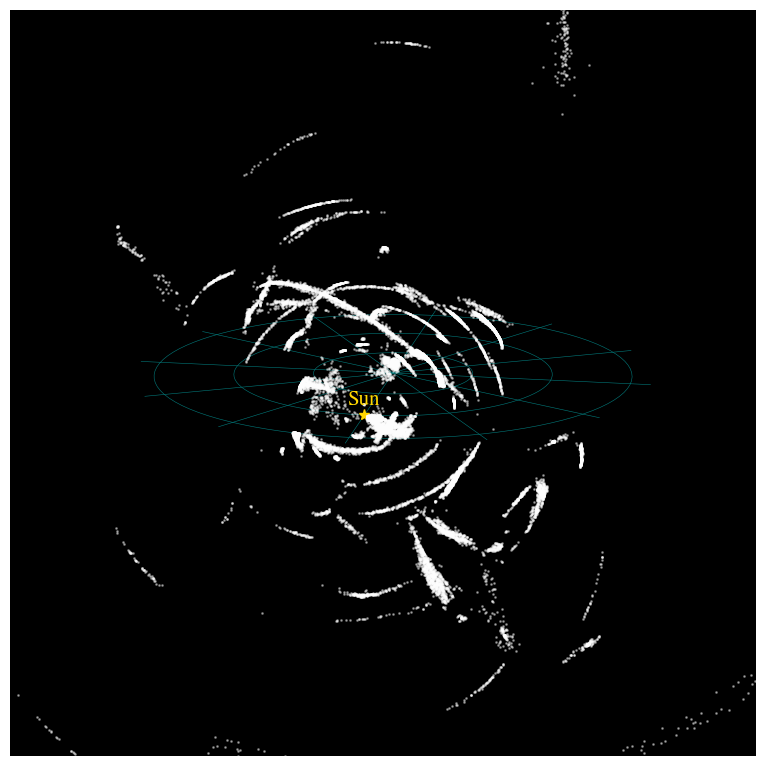

In [13]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection='3d', facecolor='k')

elev, azim, roll = 20, -7, 0
elev, azim, roll = 15, 190, 0
# elev, azim, roll = 30, 190, 0
ax.view_init(elev, azim, roll)

radii = np.array([4,8,12])
theta = np.linspace(0,2*np.pi,100)

phi = np.arange(0,360,30)*u.deg
rlims = np.linspace(0,13,2)

teal = '#027b7c'
lw_grid = 0.4

############
# plot disk 
# circular
for r in radii:
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = theta * 0
    
    plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

# radial
for p in phi:
    x = rlims * np.cos(p)
    y = rlims * np.sin(p)
    z = rlims * 0
    
    plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

# the Sun
plt.plot(-8.1,0,0.02, '*', color='gold', ms=8)
plt.gca().text(-8.3,0,0.6,'Sun', ha='center', color='gold', fontsize='small')

###############
# plot streams

for name in names[:]:
    ind = tbl['name']==name
    plt.plot(cgal.x.value[ind], cgal.y.value[ind], cgal.z.value[ind], 'wo', ms=1, alpha=0.4)


#############
# axes setup
plt.gca().set_xlim(-10,10)
plt.gca().set_ylim(-10,10)
plt.gca().set_zlim(-12,12)
# plt.gca().set_xlim(-20,20)
# plt.gca().set_ylim(-20,20)
# plt.gca().set_zlim(-45,20)

# x_range = np.diff(ax.get_xlim())[0]
# y_range = np.diff(ax.get_ylim())[0]
# z_range = np.diff(ax.get_zlim())[0]
# ax.set_box_aspect([x_range, y_range, z_range])

plt.gca().set_aspect('equal')
plt.axis('off')

plt.tight_layout()
plt.savefig('../plots/fos3d_square.png', dpi=300, bbox_inches='tight', pad_inches=0)

# # crop (ugh!)
# # Open the image
# img = Image.open('../plots/fos3d_square.png')

# # Get the dimensions
# img_width, img_height = img.size

# # Define the coordinates for cropping (left, top, right, bottom)
# crop_box = (0, int(img_height*0.15), img_width, int(img_height*0.85))
# # print(crop_box, img_width, img_height)

# # Crop the image
# cropped_img = img.crop(crop_box)

# # Save the cropped image
# cropped_img.save('../plots/fos3d.png')

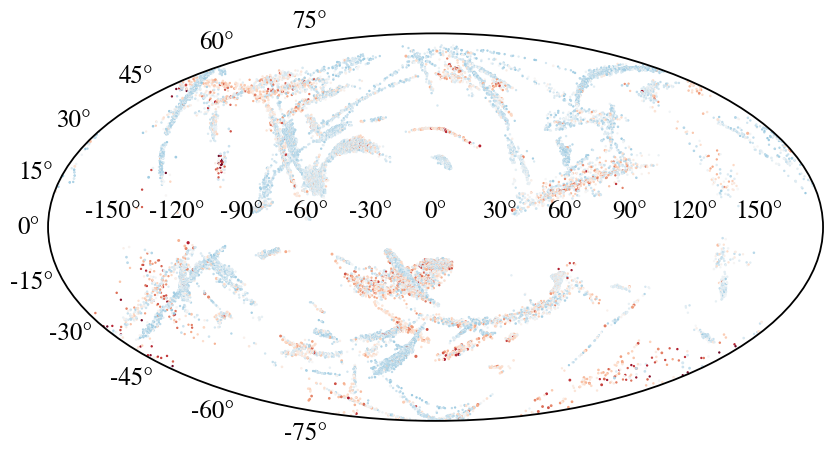

In [14]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "aitoff"})
ax.scatter(gal.l.wrap_at(180 * u.deg).radian, gal.b.radian, s=(15/tbl['Gmag0'])**3, c=tbl["BRcol0"], cmap="RdBu_r",
          vmin=0., vmax=1.8)

(20.0, 12.0)

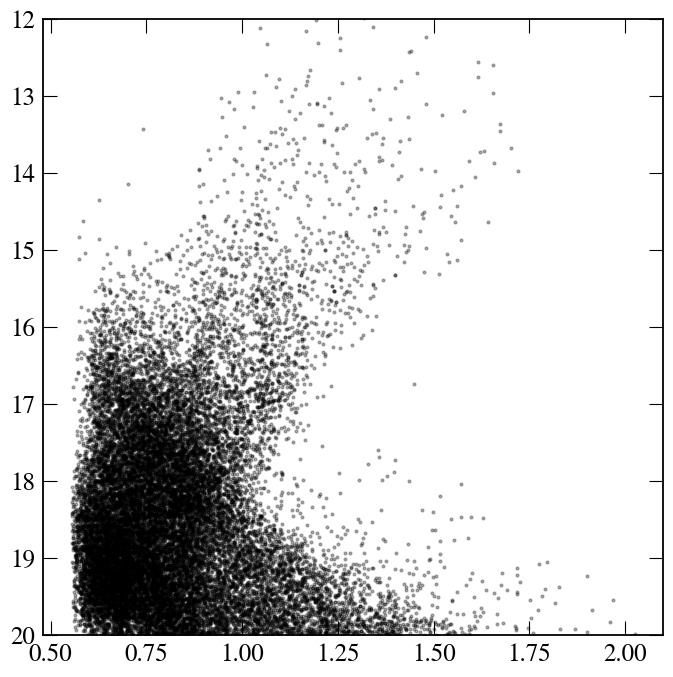

In [15]:
plt.plot(tbl['BRcol0'], tbl['Gmag0'], 'ko', ms=2, alpha=0.3)

plt.ylim(20,12)

## Interpolate missing data

In [16]:
all_data = pickle.load(open('../data/stream-orbit-fits.pkl', 'rb'))

In [17]:
for k in range(1):
    print(all_data[k+1].keys())

dict_keys(['c_fr', 'obj_data', 'p', 'orbit', 'orbit_fr'])


In [18]:
tbl = Table.read('../data/ibata_streams_full.csv')

In [19]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [20]:
# kinematic census
names = np.unique(tbl['name'])

# interpolated kinematics
dist = np.zeros(len(tbl)) * u.kpc * np.nan
pmra = np.zeros(len(tbl)) * u.mas/u.yr * np.nan
pmdec = np.zeros(len(tbl)) * u.mas/u.yr * np.nan
vr = np.zeros(len(tbl)) * u.km/u.s * np.nan

ceq = coord.SkyCoord(ra=tbl['ra']*u.deg, dec=tbl['dec']*u.deg)

dx = 3
order = 3
bbox = [-180,180]

for name in names[:]:
    ind = tbl['name']==name
    sid = tbl['sID'][ind][0]
    
    if sid in all_data:
#         print(name)
        cfr = ceq.transform_to(all_data[sid]['c_fr'])
        xmin = np.min(cfr.phi1.deg[ind]) - dx
        xmax = np.max(cfr.phi1.deg[ind]) + dx
        
        orbit = all_data[sid]['orbit_fr']
        orbit_eq = orbit.transform_to(coord.ICRS())
        ind_segment = (orbit.phi1.deg>xmin) & (orbit.phi1.deg<xmax) & (np.abs(orbit.phi2.deg)<20)
#         plt.plot(orbit.phi1.deg[ind_segment], orbit.distance[ind_segment], 'o')

        isort = np.argsort(orbit.phi1[ind_segment])
#         order = min(np.sum(ind_segment), order0)
#         print(np.sum(ind_segment), np.sum(ind))

        if np.sum(ind_segment)>order:
            # interpolate orbital tracks
            interp = {}
            interp['dist'] = InterpolatedUnivariateSpline(orbit.phi1.deg[ind_segment][isort],
                                                          orbit.distance.value[ind_segment][isort],
                                                          k=order, bbox=bbox)
            interp['pmra'] = InterpolatedUnivariateSpline(orbit.phi1.deg[ind_segment][isort],
                                                          orbit_eq.pm_ra_cosdec.value[ind_segment][isort],
                                                          k=order, bbox=bbox)
            interp['pmdec'] = InterpolatedUnivariateSpline(orbit.phi1.deg[ind_segment][isort],
                                                          orbit_eq.pm_dec.value[ind_segment][isort],
                                                          k=order, bbox=bbox)
            interp['vr'] = InterpolatedUnivariateSpline(orbit.phi1.deg[ind_segment][isort],
                                                        orbit.radial_velocity.value[ind_segment][isort],
                                                        k=order, bbox=bbox)

            dist[ind] = interp['dist'](cfr.phi1.deg[ind]) * u.kpc
            pmra[ind] = interp['pmra'](cfr.phi1.deg[ind]) * u.mas/u.yr
            pmdec[ind] = interp['pmdec'](cfr.phi1.deg[ind]) * u.mas/u.yr
            vr[ind] = interp['vr'](cfr.phi1.deg[ind]) * u.km/u.s
        else:
            dist[ind] = np.median(orbit.distance[ind_segment])
            pmra[ind] = np.median(orbit_eq.pm_ra_cosdec[ind_segment])
            pmdec[ind] = np.median(orbit_eq.pm_dec[ind_segment])
            vr[ind] = np.median(orbit.radial_velocity[ind_segment])

# plt.axhline(20)
# plt.axhline(-20)
# plt.gca().set_aspect('equal')
        

### Circular velocity

In [21]:
ind_finite = np.isfinite(dist)
t = tbl[ind_finite]
dist = dist[ind_finite]
pmra = pmra[ind_finite]
pmdec = pmdec[ind_finite]
vr = vr[ind_finite]

In [22]:
mw = gp.MilkyWayPotential2022()
galcen_frame = coord.Galactocentric(
    galcen_distance=8.275 * u.kpc, galcen_v_sun=[8.4, 251, 8.4] * u.km / u.s
)

In [23]:
# construct the 6D phase space SkyCoord object
c = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=dist, pm_ra_cosdec=t['mu_r']*u.mas/u.yr,
                   pm_dec=t['mu_d']*u.mas/u.yr, radial_velocity=vr)
# c = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, distance=dist, pm_ra_cosdec=pmra, pm_dec=pmdec, 
#                    radial_velocity=vr)
cgal = c.transform_to(galcen_frame)

In [24]:
# get circular velocity at locations of stream stars
vcirc = mw.circular_velocity([cgal.x, cgal.y, cgal.z])

In [25]:
rho = cgal.spherical.distance

In [26]:
v = np.sqrt(cgal.v_x**2 + cgal.v_y**2 + cgal.v_z**2)

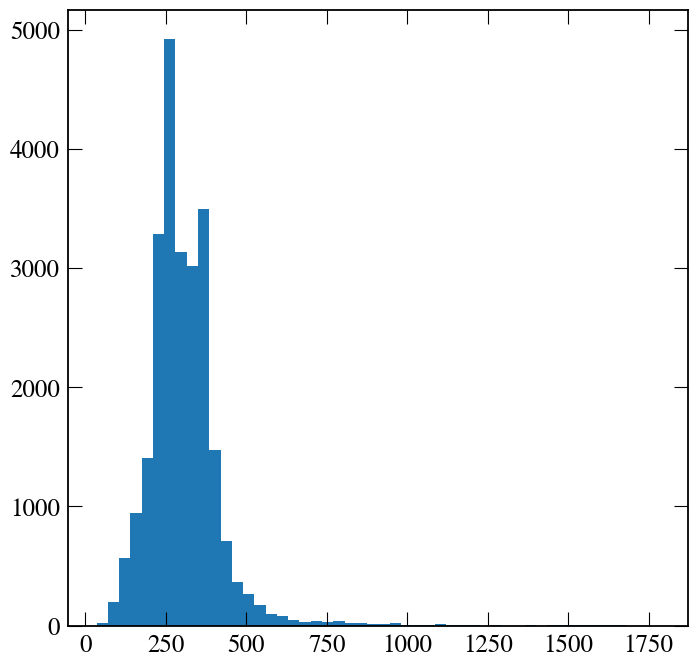

In [27]:
plt.hist(v.value, bins=50);

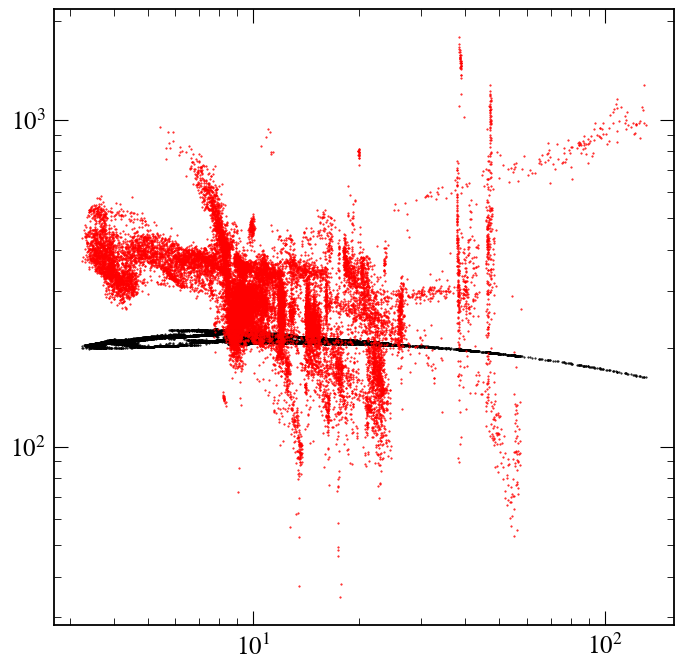

In [28]:
plt.plot(rho, vcirc, 'k.', ms=1)
plt.plot(rho, v, 'r.', ms=1)

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

### Angular momentum

In [29]:
xunit = u.kpc
x = np.array([cgal.x.to(xunit).value, cgal.y.to(xunit).value, cgal.z.to(xunit).value])

In [30]:
vunit = u.kpc/u.Myr
v = np.array([cgal.v_x.to(vunit).value, cgal.v_y.to(vunit).value, cgal.v_z.to(vunit).value])

In [31]:
L = np.cross(x,v, axis=0)

In [32]:
ltot = np.linalg.norm(L, axis=0) * xunit * vunit
lx = L[0] * xunit * vunit
ly = L[1] * xunit * vunit
lz = L[2] * xunit * vunit
lperp = np.sqrt(lx**2 + ly**2)

In [33]:
flz = (lz/ltot).decompose().value
flperp = np.sign(lz) * (lperp/ltot).decompose().value

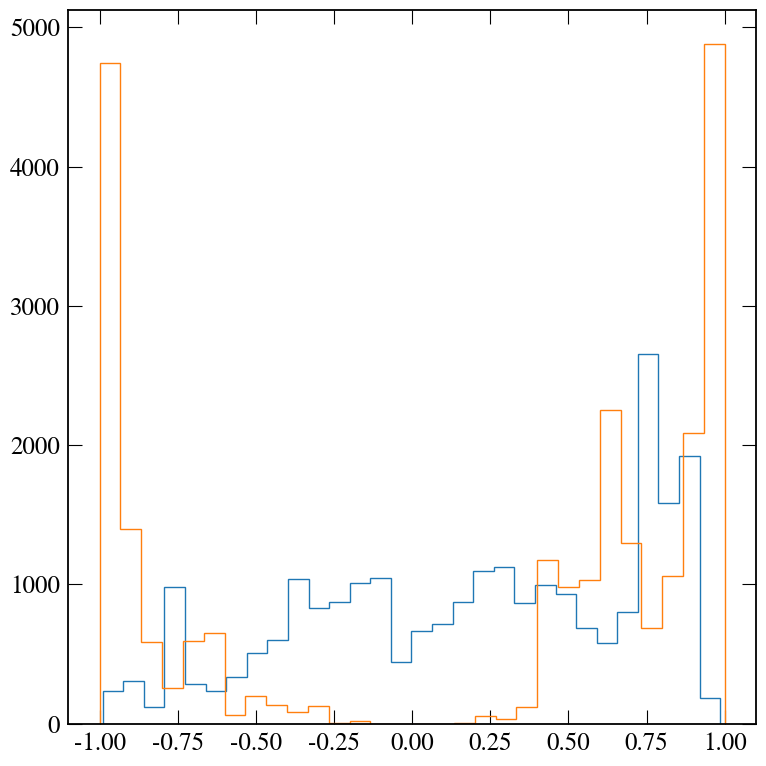

In [34]:
plt.hist(flz, bins=30, histtype='step')
plt.hist(flperp, bins=30, histtype='step')

plt.tight_layout()

In [35]:
# single flperp per stream
flperp_stream = np.zeros_like(flperp)
for name in names[:]:
    ind = t['name']==name
    flperp_stream[ind] = np.median(flperp[ind])

/usr/local/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


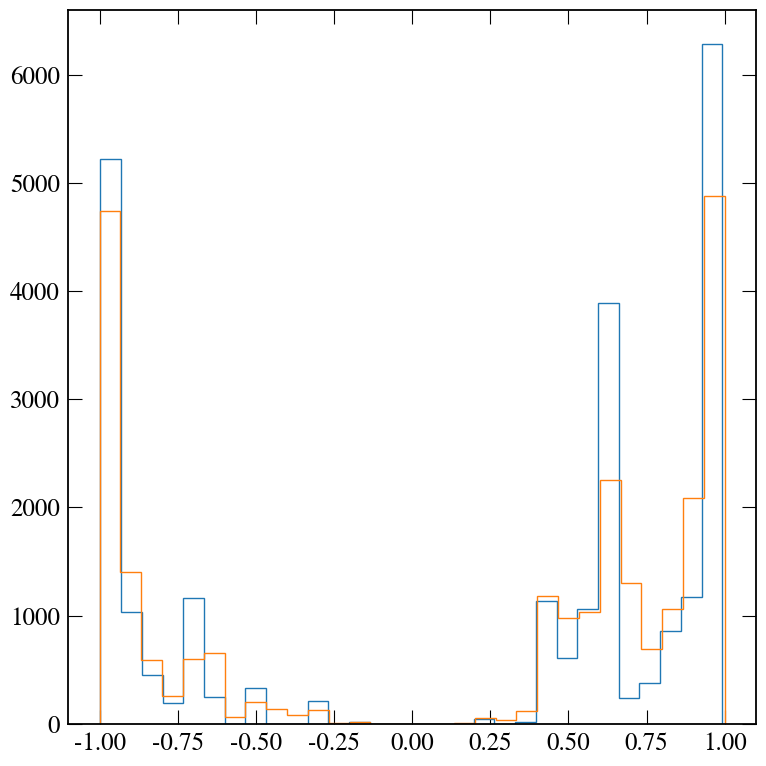

In [36]:
plt.hist(flperp_stream, bins=30, histtype='step')
plt.hist(flperp, bins=30, histtype='step')

plt.tight_layout()

## Figure

In [37]:
len(names)

87

In [38]:
tsum = Table.read('../data/tmp_summary_table.csv')
ind_oc = tsum['Name']=='OC'
tsum['Name'][ind_oc] = 'Orphan-Chenab'

In [39]:
np.nanmedian(tsum['Stellar Mass'])

9138.20368836352

In [40]:
print(tsum.colnames)

['Name', 'Origin RA', 'Origin Dec.', '$D_{\\rm hel}$', '$r_{\\rm gal}$', 'Length (sky)', 'Width (sky)', 'Width', 'Reference', 'Width Ref.', 'Stellar Mass', 'Stellar Mass Ref.', 'Distance Ref.', 'Found in Gaia', 'Spec. Follow Up', 'Spec. Ref.']


In [41]:
ind_full = (tsum['Found in Gaia']=='True') & (tsum['Spec. Follow Up']=='True') & (tsum['Name']!='300S')
ind_dist = np.argmax(tsum['$r_{\\rm gal}$'][ind_full])

In [42]:
tsum[ind_full][ind_dist]

Name,Origin RA,Origin Dec.,$D_{\rm hel}$,$r_{\rm gal}$,Length (sky),Width (sky),Width,Reference,Width Ref.,Stellar Mass,Stellar Mass Ref.,Distance Ref.,Found in Gaia,Spec. Follow Up,Spec. Ref.
str13,float64,float64,float64,float64,float64,float64,float64,str19,str19,float64,str19,str19,str5,str5,str96
Kwando,24.154505612124964,-12.259202452809129,49.99999999951429,52.9710592164157,63.61565303846331,2.8325142071249685,2411.9817974511075,2023arXiv231117202I,this work,191528.54511971938,this work,this work,True,True,['']


In [43]:
ind_gaia = (tsum['Found in Gaia']=='True')
ind_long = np.argmax(tsum['Length (sky)'])
tsum[ind_long]

Name,Origin RA,Origin Dec.,$D_{\rm hel}$,$r_{\rm gal}$,Length (sky),Width (sky),Width,Reference,Width Ref.,Stellar Mass,Stellar Mass Ref.,Distance Ref.,Found in Gaia,Spec. Follow Up,Spec. Ref.
str13,float64,float64,float64,float64,float64,float64,float64,str19,str19,float64,str19,str19,str5,str5,str96
Orphan-Chenab,12.671625816626142,63.95217443844767,18.333170838699655,23.73987850813172,210.0,0.8430207255158786,462.5946773385185,2023MNRAS.521.4936K,2023MNRAS.521.4936K,560000.0,2023MNRAS.521.4936K,this work,True,True,"['2019MNRAS.490.3508L', '2020AJ....160..181J', '2022ApJ...928...30L', '2023MNRAS.521.4936K', '']"


In [44]:
ind_close = np.argmin(tsum['$D_{\\rm hel}$'])

In [45]:
tsum[ind_close]

Name,Origin RA,Origin Dec.,$D_{\rm hel}$,$r_{\rm gal}$,Length (sky),Width (sky),Width,Reference,Width Ref.,Stellar Mass,Stellar Mass Ref.,Distance Ref.,Found in Gaia,Spec. Follow Up,Spec. Ref.
str13,float64,float64,float64,float64,float64,float64,float64,str19,str19,float64,str19,str19,str5,str5,str96
New-3,34.013697691117265,4.682480978209314,1.0340488303533308,8.754461607243586,61.85369304980688,4.749382456478166,99.87997716197405,2023arXiv231117202I,this work,570.2352914180602,this work,this work,True,True,['']


In [46]:
ind_finite = np.isfinite(tsum['Width (sky)'])
ind_thin = np.argmin(tsum['Width (sky)'][ind_finite])
ind_wide = np.argmax(tsum['Width (sky)'][ind_finite])

In [47]:
tsum[ind_finite][ind_thin]

Name,Origin RA,Origin Dec.,$D_{\rm hel}$,$r_{\rm gal}$,Length (sky),Width (sky),Width,Reference,Width Ref.,Stellar Mass,Stellar Mass Ref.,Distance Ref.,Found in Gaia,Spec. Follow Up,Spec. Ref.
str13,float64,float64,float64,float64,float64,float64,float64,str19,str19,float64,str19,str19,str5,str5,str96
C-20,358.35004401016164,10.998146629434153,21.127227602113305,23.537438992511255,18.618768601258665,0.07203873176701181,26.652770713517857,2023arXiv231117202I,this work,55261.60925525754,this work,this work,True,True,['']


In [48]:
nstar = np.zeros(len(names), dtype=int)
for e, name in enumerate(names):
    ind = t['name']==name
    nstar[e] = np.sum(ind)

In [49]:
ind_mmem = np.argmax(nstar)

In [50]:
names[ind_mmem], nstar[ind_mmem]

('Fimbulthul', 3724)

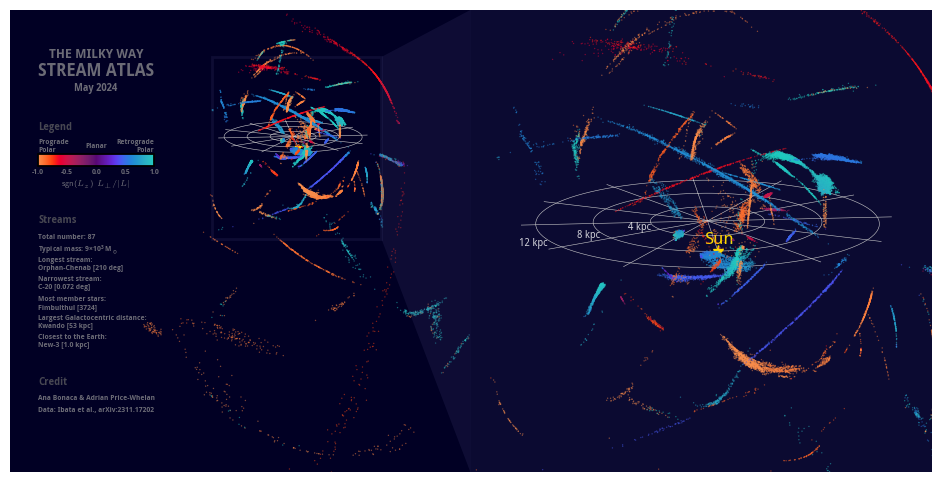

In [51]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Droid Sans']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection='3d', facecolor='#010024')
# ax2 = fig.add_subplot(122, projection='3d', facecolor='#03002e')
bg_navy = '#0b0a31'
ax2 = fig.add_subplot(122, projection='3d', facecolor=bg_navy)

elev, azim, roll = 15, 175, 0
ax1.view_init(elev, azim, roll)

elev, azim, roll = 15, 175, 0
ax2.view_init(elev, azim, roll)

radii = np.array([4,8,12])
theta = np.linspace(0,2*np.pi,100)

phi = np.arange(0,360,30)*u.deg
rlims = np.linspace(0,13,2)

teal = '#027b7c'
teal = '#59ff22'
teal = '#90ff6b'
teal = '0.8'
lw_grid = 0.4
sizes = [5,8]

for e, ax in enumerate([ax1, ax2]):
    plt.sca(ax)
    plt.axis('off')
    
    ############
    # plot disk 
    # circular
    for r in radii:
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        z = theta * 0

        plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

    # radial
    for p in phi:
        x = rlims * np.cos(p)
        y = rlims * np.sin(p)
        z = rlims * 0

        plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

    # the Sun
    plt.plot(-8.1,0,0.02, '*', color='gold', ms=sizes[e])
        
    ###############
    # plot streams

    for name in names[:]:
        ind = t['name']==name
        im = ax.scatter(cgal.x.value[ind], cgal.y.value[ind], cgal.z.value[ind], c=flperp[ind], cmap=cmr.guppy,
                  vmin=-1, vmax=1, ec='none', s=1, alpha=0.5)

plt.rcParams['font.weight'] = 'normal'

# the Sun
plt.gca().text(-8.3, 0, 0.6, 'Sun', ha='center', color='gold', fontsize='x-small')

# radii
dr = 0.6
ap = 0.97
for i in range(3):
    ax2.text((radii[i]+dr)*np.cos(ap*phi[4]), (radii[i]+dr)*np.sin(ap*phi[4]), 0, '{:.0f} kpc'.format(radii[i]),
             fontsize=7, color='w', alpha=0.8, ha='right')

plt.rcParams['font.weight'] = 'bold'

#############
# axes setup
ax2.set_xlim(-10,10)
ax2.set_ylim(-10,10)
ax2.set_zlim(-6,4)
ax2.set_aspect('equal', adjustable='datalim')

ax1.set_xlim(-10,10)
ax1.set_ylim(-10,10)
ax1.set_ylim(-2,18)
ax1.set_zlim(-55,20)
ax1.set_aspect('equal')

wspace = -0.02
plt.subplots_adjust(wspace=wspace, hspace=0)


#####################
# Zoomed in rectangle

# Function to transform 3D points to 2D display coordinates
def transform_to_2d(ax, point_3d):
    point_3d_h = np.append(point_3d, 1)
    proj_matrix = ax.get_proj()
    point_2d_h = proj_matrix @ point_3d_h
    point_2d = point_2d_h[:2] / point_2d_h[3]
    display_point = ax.transData.transform(point_2d)
    return display_point

# Get the actual data limits displayed in the zoomed-in axes
data_lim = ax2.dataLim
zlim = np.array(ax2.get_zlim())
zlim_scale = zlim * (data_lim.x1-data_lim.x0)/(zlim[1]-zlim[0])

# Get the corners of the actual data limits
corners = np.array([
    [data_lim.xmin, data_lim.ymin, zlim_scale[0]],
    [data_lim.xmin, data_lim.ymin, zlim_scale[1]],
    [data_lim.xmin, data_lim.ymax, zlim_scale[0]],
    [data_lim.xmin, data_lim.ymax, zlim_scale[1]],
    [data_lim.xmax, data_lim.ymin, zlim_scale[0]],
    [data_lim.xmax, data_lim.ymin, zlim_scale[1]],
    [data_lim.xmax, data_lim.ymax, zlim_scale[0]],
    [data_lim.xmax, data_lim.ymax, zlim_scale[1]]
])

# Transform the corners to 2D display coordinates in the zoomed-out axes
corners_2d = np.array([transform_to_2d(ax1, corner) for corner in corners])

# Find the bounding box in 2D coordinates
min_x, min_y = np.min(corners_2d, axis=0)
max_x, max_y = np.max(corners_2d, axis=0)

# Transform display coordinates to figure coordinates
def display_to_figure(display_point, fig):
    return fig.transFigure.inverted().transform(display_point)

# Get figure coordinates of the bounding box
bottom_left = display_to_figure([min_x, min_y], fig)
top_right = display_to_figure([max_x, max_y], fig)

# Draw a rectangle in figure coordinates
rect = mpl.patches.Rectangle(bottom_left, top_right[0] - bottom_left[0], top_right[1] - bottom_left[1],
                 linewidth=2, edgecolor='#434177', alpha=0.2, facecolor='none', transform=fig.transFigure, zorder=0)
fig.patches.append(rect)

# Draw a connecting trapeze in figure coordinates
bbox1_display = ax1.get_window_extent()
bbox1_fig = bbox1_display.transformed(fig.transFigure.inverted())

aw = 0.23
dw = 1e-3
poly_vertices = np.array([[top_right[0]+dw, top_right[1]+dw], 
                          [bbox1_fig.x1+aw*wspace, bbox1_fig.y1], 
                          [bbox1_fig.x1+aw*wspace, bbox1_fig.y0], 
                          [top_right[0]+dw, bottom_left[1]-dw]])
polygon = mpl.patches.Polygon(poly_vertices,
                 linewidth=0, edgecolor='#434177', alpha=0.2, facecolor='#434177', transform=fig.transFigure, zorder=0)
fig.patches.append(polygon)

#############
# Annotations
tcolor = '#999999'
tcolor2 = '#666666'
talpha=0.7
fig.text(0.2,0.8,'THE MILKY WAY', color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=9, ha='center')
title_text = fig.text(0.2,0.77,'STREAM ATLAS', color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=12, ha='center')
fig.text(0.2,0.745,'May 2024', color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=7, ha='center')

bbox = title_text.get_window_extent(renderer=fig.canvas.get_renderer())
bbox_fig = bbox.transformed(fig.transFigure.inverted())

x0 = bbox_fig.x0
x1 = bbox_fig.x1
wx = x1-x0

########
# Legend
ylegend = 0.68
fig.text(x0, ylegend,'Legend', color=tcolor2, transform=fig.transFigure, alpha=talpha, fontsize=7, ha='left')

# colorbar
dy_cbar = 0.06
cbar_pos = [x0, ylegend-dy_cbar, wx, 0.02]
cbar_ax = fig.add_axes(cbar_pos)

# dummy scalar mappable
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
sm = mpl.cm.ScalarMappable(cmap=cmr.guppy, norm=norm)
sm.set_array([])

colorbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
colorbar.ax.tick_params(labelcolor=tcolor, labelsize=5, pad=2, size=0)
for label in colorbar.ax.get_xticklabels():
    label.set_alpha(talpha)

colorbar.set_label(r'sgn($L_z$) $L_\perp/|L|$', fontsize=6, color=tcolor, alpha=talpha, labelpad=2.5, usetex=True)

dy_legend = 0.028
fig.text(x0, ylegend - dy_legend,'Prograde\nPolar', color=tcolor, transform=fig.transFigure, alpha=talpha, 
         fontsize=5, ha='left', va='center')
fig.text(x0+0.5*wx, ylegend - dy_legend,'Planar', color=tcolor, transform=fig.transFigure, alpha=talpha, 
         fontsize=5, ha='center', va='center')
fig.text(x1, ylegend - dy_legend,'Retrograde\nPolar', color=tcolor, transform=fig.transFigure, alpha=talpha, 
         fontsize=5, ha='right', va='center')



# Streams
ystreams = 0.525
dy_streams0 = 0.018
dy_streams1 = 0.017
dy_streams2 = 0.022
dy_streams3 = 0.032
fig.text(x0, ystreams, 'Streams', color=tcolor2, transform=fig.transFigure, alpha=talpha, fontsize=7, ha='left')
fig.text(x0, ystreams-dy_streams0,
         'Total number: {:d}'.format(len(names)),
         color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=5, ha='left', va='top')
fig.text(x0, ystreams-dy_streams0-dy_streams1,
         'Typical mass: {:.0f}$\\times10^3$ $M_\odot$'.format(np.nanmedian(tsum['Stellar Mass'])*1e-3),
         color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=5, ha='left', va='top')

fig.text(x0, ystreams-dy_streams0-dy_streams1-dy_streams2,
         'Longest stream:\n{:s} [{:.0f} deg]'.format(tsum[ind_long]['Name'], tsum[ind_long]['Length (sky)']),
         color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=5, ha='left', va='top')
fig.text(x0, ystreams-dy_streams0-dy_streams1-dy_streams2-dy_streams3,
         'Narrowest stream:\n{:s} [{:.3f} deg]'.format(tsum[ind_finite][ind_thin]['Name'], 
                                                       tsum[ind_finite][ind_thin]['Width (sky)']),
         color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=5, ha='left', va='top')
fig.text(x0, ystreams-dy_streams0-dy_streams1-dy_streams2-2*dy_streams3,
         'Most member stars:\n{:s} [{:d}]'.format(names[ind_mmem], nstar[ind_mmem]),
         color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=5, ha='left', va='top')
fig.text(x0, ystreams-dy_streams0-dy_streams1-dy_streams2-3*dy_streams3,
         'Largest Galactocentric distance:\n{:s} [{:.0f} kpc]'.format(tsum[ind_full][ind_dist]['Name'],
                                                     tsum[ind_full][ind_dist]['$r_{\\rm gal}$']),
         color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=5, ha='left', va='top')
fig.text(x0, ystreams-dy_streams0-dy_streams1-dy_streams2-4*dy_streams3,
         'Closest to the Earth:\n{:s} [{:.1f} kpc]'.format(tsum[ind_close]['Name'],
                                                          tsum[ind_close]['$D_{\\rm hel}$']),
         color=tcolor, transform=fig.transFigure, alpha=talpha, fontsize=5, ha='left', va='top')



# Credits
fig.text(x0,0.255,'Credit', color=tcolor2, transform=fig.transFigure, alpha=talpha, fontsize=7, ha='left')
fig.text(x0,0.23,'Ana Bonaca & Adrian Price-Whelan', color=tcolor, transform=fig.transFigure, alpha=talpha, 
         fontsize=5, ha='left')
fig.text(x0,0.213,'Data: Ibata et al., arXiv:2311.17202', color=tcolor, transform=fig.transFigure, alpha=talpha, 
         fontsize=5, ha='left', va='center')


plt.savefig('../plots/fos_3d_.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.savefig('../tex/figures/fos_3d.pdf', bbox_inches='tight', pad_inches=0)
plt.savefig('../plots/fos_3d.png', dpi=300, bbox_inches='tight', pad_inches=0)

### Choose orientation

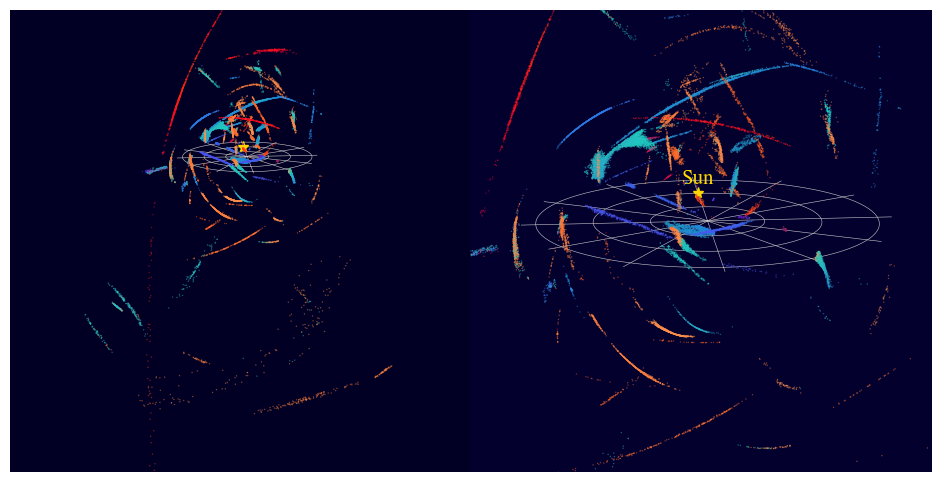

In [36]:
for a in range(0,360,5):
    plt.close()
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121, projection='3d', facecolor='#010024')
    ax2 = fig.add_subplot(122, projection='3d', facecolor='#03002e')

    elev, azim, roll = 15, a, 0
    ax1.view_init(elev, azim, roll)
    ax2.view_init(elev, azim, roll)

    radii = np.array([4,8,12])
    theta = np.linspace(0,2*np.pi,100)

    phi = np.arange(0,360,30)*u.deg
    rlims = np.linspace(0,13,2)

    teal = '#027b7c'
    teal = '#59ff22'
    teal = '#90ff6b'
    teal = '0.8'
    lw_grid = 0.4

    for ax in [ax1, ax2]:
        plt.sca(ax)
        plt.axis('off')

        ############
        # plot disk 
        # circular
        for r in radii:
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            z = theta * 0

            plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

        # radial
        for p in phi:
            x = rlims * np.cos(p)
            y = rlims * np.sin(p)
            z = rlims * 0

            plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

        # the Sun
        plt.plot(-8.1,0,0.02, '*', color='gold', ms=8)

        ###############
        # plot streams

        for name in names[:]:
            ind = t['name']==name
    #         plt.plot(cgal.x.value[ind], cgal.y.value[ind], cgal.z.value[ind], 'wo', mew=0, ms=1, alpha=0.4)
            ax.scatter(cgal.x.value[ind], cgal.y.value[ind], cgal.z.value[ind], c=flperp[ind], cmap=cmr.guppy,
                      vmin=-1, vmax=1, ec='none', s=1, alpha=0.5)

    # the Sun
    # plt.plot(-8.1,0,0.02, '*', color='gold', ms=8)
    plt.gca().text(-8.3,0,0.6,'Sun', ha='center', color='gold', fontsize='small')

#     point_to_annotate = (20, 7)
#     ax1.annotate('Annotation Text', xy=point_to_annotate, xytext=(10, 5),
#                 arrowprops=dict(facecolor='r', arrowstyle='->'))


    #############
    # axes setup
    ax2.set_xlim(-10,10)
    ax2.set_ylim(-10,10)
    ax2.set_zlim(-6,4)
    ax2.set_aspect('equal')

    ax1.set_xlim(-10,10)
    ax1.set_ylim(-10,10)
    ax1.set_zlim(-35,5)
    ax1.set_aspect('equal')

    plt.subplots_adjust(wspace=-0.02, hspace=0)
    plt.savefig('../plots/fos_3d_{:03d}.png'.format(azim), dpi=300, bbox_inches='tight', pad_inches=0)


### Promo

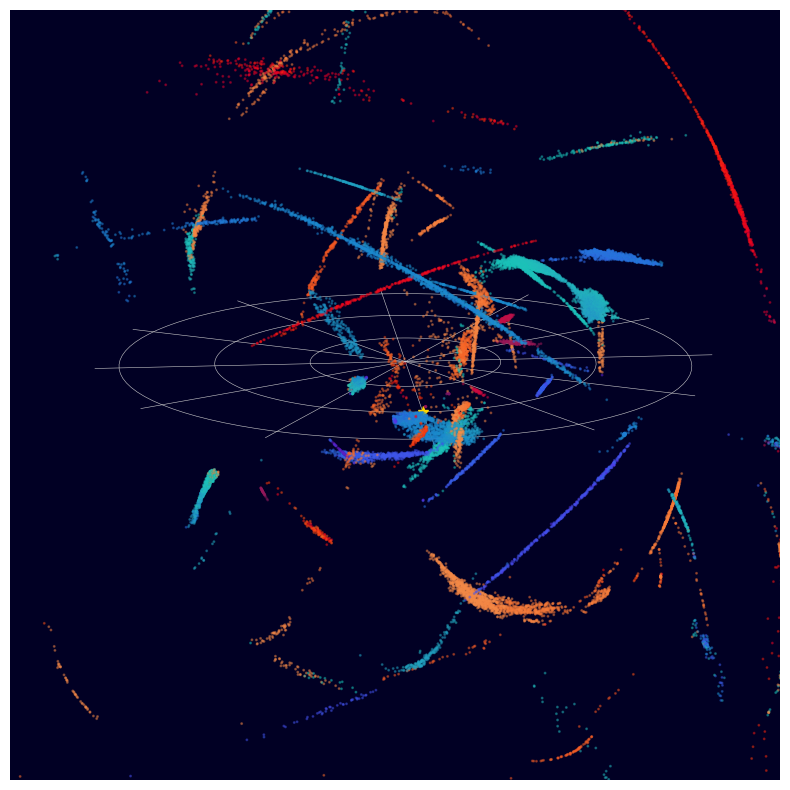

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', facecolor='#010024')

elev, azim, roll = 15, 175, 0
ax.view_init(elev, azim, roll)

radii = np.array([4,8,12])
theta = np.linspace(0,2*np.pi,100)

phi = np.arange(0,360,30)*u.deg
rlims = np.linspace(0,13,2)

teal = '0.8'
lw_grid = 0.4

plt.sca(ax)
plt.axis('off')

############
# plot disk 
# circular
for r in radii:
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = theta * 0

    plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

# radial
for p in phi:
    x = rlims * np.cos(p)
    y = rlims * np.sin(p)
    z = rlims * 0

    plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

# the Sun
plt.plot(-8.1,0,0.02, '*', color='gold', ms=8)

###############
# plot streams

Na = 10
alphas = np.ones(Na)*0.1
sizes = ((np.arange(Na)*0.5+0.1)**1.1)[::-1]

for name in names[:]:
    ind = t['name']==name
    for i in range(Na):
        ax.scatter(cgal.x.value[ind], cgal.y.value[ind], cgal.z.value[ind], c=flperp[ind], cmap=cmr.guppy,
                  vmin=-1, vmax=1, ec='none', s=sizes[i], alpha=alphas[i])

# the Sun
# plt.gca().text(-8.3,0,0.6,'Sun', ha='center', color='gold', fontsize='small')


#############
# axes setup

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-6,4)
ax.set_aspect('equal')

plt.subplots_adjust(wspace=-0.02, hspace=0)
plt.savefig('../plots/fos_3d_promo.png', dpi=300, bbox_inches='tight', pad_inches=0)